In [1]:
# Cell 1: Setup for Negative Binomial

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv("SeoulBikeDataClean.csv")
df = df[df['functioning_day'] == 'Yes'].copy()
# Ensure categorical variables are converted
df['hour'] = df['hour'].astype('category')
df['seasons'] = df['seasons'].astype('category')
df['is_raining'] = df['is_raining'].astype('category')
df['is_snowing'] = df['is_snowing'].astype('category')
df['is_holiday'] = df['is_holiday'].astype('category')
df['is_working_day'] = df['is_working_day'].astype('category')

print("✅ Data loaded and categories set.")


✅ Data loaded and categories set.


In [2]:
# Cell 2: Build and fit NB model

# 定义公式
formula = (
    'rented_bike_count ~ temperaturec + temperaturec_squared + solar_radiation_mj_m2 + '
    'C(hour) + C(seasons) + C(is_raining) + C(is_snowing) + '
    'C(is_holiday) + C(is_working_day)'
)

# 拟合负二项回归模型（GLM）
nb_model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 8465
Model:                            GLM   Df Residuals:                     8431
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61096.
Date:                Mon, 12 May 2025   Deviance:                       2159.0
Time:                        17:39:37   Pearson chi2:                 1.73e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5277
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Train RMSE: 312.82
Train R²: 0.7628


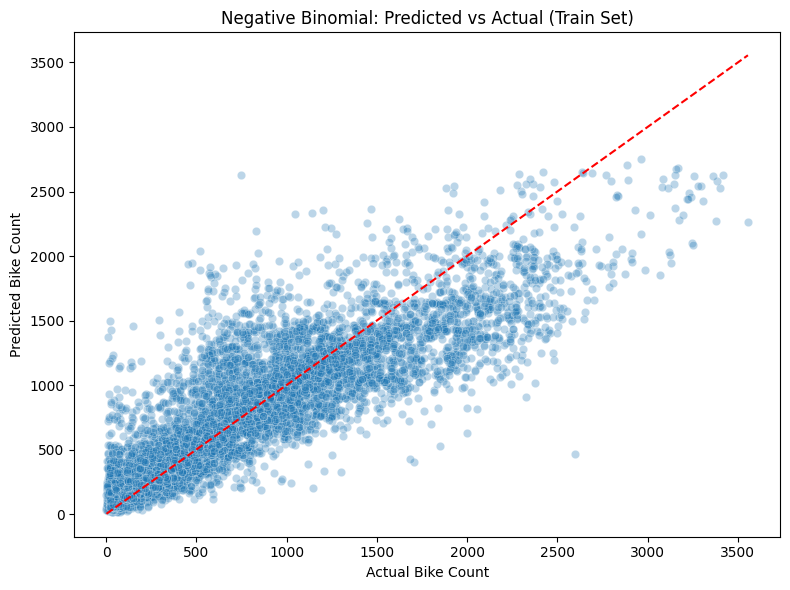

In [3]:
# Cell 3: Predict and evaluate NB model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 预测训练集
y_true = df['rented_bike_count']
y_pred = nb_model.predict(df)

# 评估指标
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"Train RMSE: {rmse:.2f}")
print(f"Train R²: {r2:.4f}")

# 可视化：预测 vs 实际
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Negative Binomial: Predicted vs Actual (Train Set)")
plt.tight_layout()
plt.show()


In [4]:
# Cell 4: 查看实际租赁量为 0 的样本数量
zero_count = (df['rented_bike_count'] == 0).sum()
zero_pct = zero_count / len(df)

print(f"🧾 Total observations: {len(df)}")
print(f"🔍 Zero rentals count: {zero_count}")
print(f"📉 Percentage of zero-rental rows: {zero_pct:.2%}")


🧾 Total observations: 8465
🔍 Zero rentals count: 0
📉 Percentage of zero-rental rows: 0.00%


         predicted
count  8465.000000
mean    719.886814
std     539.056413
min      15.964787
25%     250.849076
50%     586.439307
75%    1102.369751
max    2752.418246


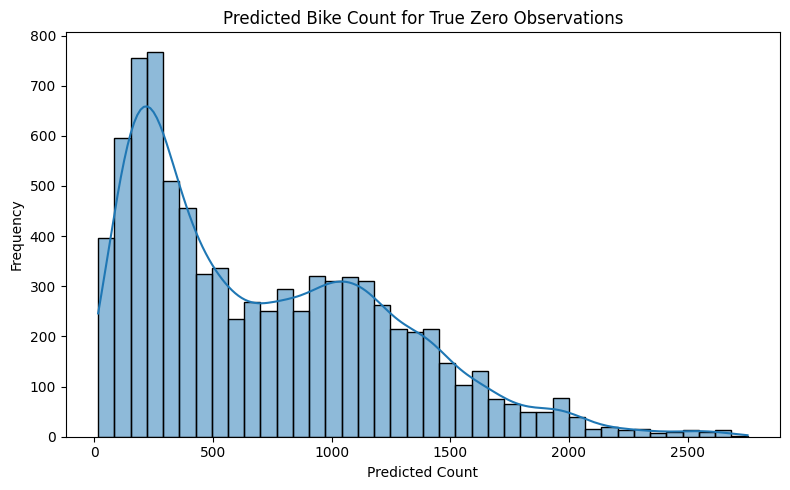

In [5]:
# Cell 5: 实际为 0 的样本被预测了什么
df_zero = df[df['rented_bike_count'] == 0].copy()
df_zero['predicted'] = y_pred

# 查看 top 被高估的样本
print(df_zero[['predicted']].describe())

# 可视化这些错误预测
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_zero['predicted'], bins=40, kde=True)
plt.title("Predicted Bike Count for True Zero Observations")
plt.xlabel("Predicted Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [6]:
# Cell 6: Create zero-risk indicator variables

df['is_midnight'] = df['hour'].astype(int).isin([0, 1, 2, 3, 4, 5]).astype('category')
df['is_extreme_cold'] = (df['temperaturec'] < -5).astype('category')
df['is_low_radiation'] = (df['solar_radiation_mj_m2'] < 0.2).astype('category')

print("✅ New indicator variables added:")
print(df[['hour', 'temperaturec', 'solar_radiation_mj_m2',
          'is_midnight', 'is_extreme_cold', 'is_low_radiation']].head())


✅ New indicator variables added:
  hour  temperaturec  solar_radiation_mj_m2 is_midnight is_extreme_cold  \
0    0          -5.2                    0.0        True            True   
1    1          -5.5                    0.0        True            True   
2    2          -6.0                    0.0        True            True   
3    3          -6.2                    0.0        True            True   
4    4          -6.0                    0.0        True            True   

  is_low_radiation  
0             True  
1             True  
2             True  
3             True  
4             True  


In [7]:
# Cell 7: Refit NB with added zero-indicator features

# 更新模型公式
formula_updated = (
    'rented_bike_count ~ temperaturec + temperaturec_squared + solar_radiation_mj_m2 + '
    'C(hour) + C(seasons) + C(is_raining) + C(is_snowing) + '
    'C(is_holiday) + C(is_working_day) + '
    'C(is_midnight) + C(is_extreme_cold) + C(is_low_radiation)'
)

# 拟合
nb_model_updated = smf.glm(
    formula=formula_updated,
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model_updated.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 8465
Model:                            GLM   Df Residuals:                     8429
Model Family:        NegativeBinomial   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61074.
Date:                Mon, 12 May 2025   Deviance:                       2114.8
Time:                        17:39:38   Pearson chi2:                 1.71e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5302
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


count    8465.000000
mean      721.563964
std       551.571570
min        14.686331
25%       247.779266
50%       578.295938
75%      1090.191532
max      2908.168217
Name: predicted, dtype: float64


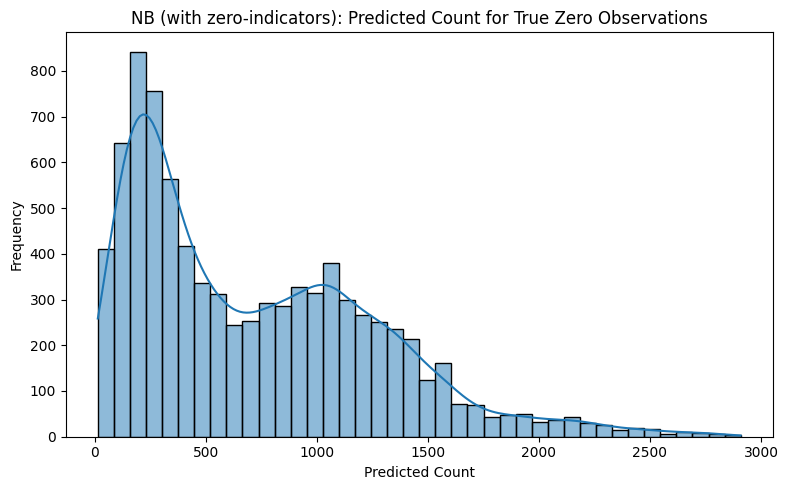

In [8]:
# Cell 8: Check updated prediction on zero-true samples

# 获取预测值
df['nb_pred_updated'] = nb_model_updated.predict()

# 提取实际为 0 的样本
df_zero_updated = df[df['rented_bike_count'] == 0].copy()
df_zero_updated['predicted'] = df['nb_pred_updated']

# 分析新模型在这些样本上的表现
print(df_zero_updated['predicted'].describe())

# 绘图
plt.figure(figsize=(8, 5))
sns.histplot(df_zero_updated['predicted'], bins=40, kde=True)
plt.title("NB (with zero-indicators): Predicted Count for True Zero Observations")
plt.xlabel("Predicted Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# XGBOOST

In [9]:
# Cell 1: Setup XGBoost environment

# !pip install xgboost --quiet

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

print("✅ XGBoost and dependencies ready.")


✅ XGBoost and dependencies ready.


In [10]:
# Cell 2: Define features and build XGBoost pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# 特征分组
numeric_features = ['temperaturec', 'temperaturec_squared', 'solar_radiation_mj_m2']
categorical_features = [
    'hour', 'seasons', 'is_raining', 'is_snowing',
    'is_holiday', 'is_working_day',
    'is_midnight', 'is_extreme_cold', 'is_low_radiation'
]

# 特征 + 标签
X = df[numeric_features + categorical_features]
y = df['rented_bike_count']

# 预处理器：数值归一化 + 类别 OneHot 编码
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 建立完整 Pipeline
xgb_model = make_pipeline(
    preprocessor,
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
)

print("✅ XGBoost pipeline ready.")


✅ XGBoost pipeline ready.


XGBoost Train RMSE: 197.09
XGBoost Train R²: 0.9058


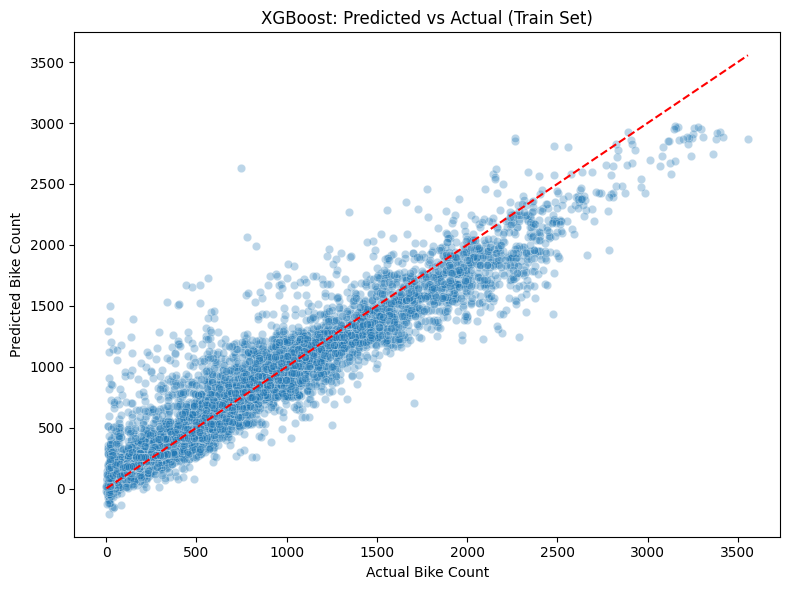

In [11]:
# Cell 3: Fit XGBoost model and evaluate on training set

# 拟合模型
xgb_model.fit(X, y)

# 预测
y_pred_xgb = xgb_model.predict(X)

# 评估指标
rmse_xgb = mean_squared_error(y, y_pred_xgb, squared=False)
r2_xgb = r2_score(y, y_pred_xgb)

print(f"XGBoost Train RMSE: {rmse_xgb:.2f}")
print(f"XGBoost Train R²: {r2_xgb:.4f}")

# 可视化预测 vs 实际
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred_xgb, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("XGBoost: Predicted vs Actual (Train Set)")
plt.tight_layout()
plt.show()


In [12]:
# Cell 5 (完整版): 分析真实为 0 的观测点是否异常

# 修正 datetime 类型（只需做一次）
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 再提取一次 0 样本
df_zero = df[df['rented_bike_count'] == 0]

# 1. 每小时分布
print("=== Hour Distribution of Zero Counts ===")
print(df_zero['hour'].value_counts().sort_index())

# 2. 每月分布
print("\n=== Month Distribution of Zero Counts ===")
print(df_zero['datetime'].dt.month.value_counts().sort_index())

# 3. 温度特征
print("\n=== Temperature Stats (Zero Samples) ===")
print(df_zero['temperaturec'].describe())

# 4. 太阳辐射强度
print("\n=== Solar Radiation Stats (Zero Samples) ===")
print(df_zero['solar_radiation_mj_m2'].describe())

# 5. 是否假日分布
print("\n=== Holiday Distribution (Zero Samples) ===")
print(df_zero['is_holiday'].value_counts())

# 6. 是否功能日（非周末/非维护）分布
print("\n=== Functioning Day (Zero Samples) ===")
print(df_zero['functioning_day'].value_counts())



=== Hour Distribution of Zero Counts ===
hour
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
Name: count, dtype: int64

=== Month Distribution of Zero Counts ===
Series([], Name: count, dtype: int64)

=== Temperature Stats (Zero Samples) ===
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: temperaturec, dtype: float64

=== Solar Radiation Stats (Zero Samples) ===
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: solar_radiation_mj_m2, dtype: float64

=== Holiday Distribution (Zero Samples) ===
is_holiday
0    0
1    0
Name: count, dtype: int64

=== Functioning Day (Zero Samples) ===
Series([], Name: count, dtype: int64)
